#Twitter Airline Sentiment Analysis
### CIS 545 Final Project
### Yuchen Ding: ycding@seas.upenn.edu
### Xi He: xhe93@seas.upenn.edu
### Yibo Yang: ybyang@seas.upenn.edu

Every day,  people write their comments,  reviews,  and blogs on Twitter toexpress their feelings and opinions toward some news and events.  Because of globalization, there are tens of thousands of air flights among various coun-tries  and  cities.   Understanding  passengers’  feelings  and  comments  abouttheir flights will help various airlines to provide better services for passen-gers.  Machine Learning will help airlines to objectively and efficiently classifythe sentiment of tweets.  Therefore, in this project, we want to use some machine learning methods to classify the sentiment (negative,positive/neutral)of tweets.

## Introduction

In this project, we would like to use the knowledge we have learnt in classto do natural language processing analysis on the airline data we found inthe previous link.  Such supervised learning approaches would be very usefulto predict the user’s opinion based on their review. \

We would like to randomly split the data set into three parts:  training,testing  and  validation.   The  ultimate  goal  for  the  proposed  project  is  to accurately predict the users’ opinion of the airline they take based on theircomments in the review panel.  We would like to use the prediction accuracyas the quantity to justify our model’s performance.

We plan to implement multiclass classification models for the predictionof sentiments:  positive, negative, and neutral.  We are considering DecisionTree, SVC, AdaBoost and Random Forest methods.



## Import Libraries

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Load Data

In [ ]:
drive.mount('/content/drive')
csv_file = open("/content/drive/My Drive/Tweets.csv")
data = pd.read_csv(csv_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploratary Data Analysis (Part I)

### Overview

The original data could be found on the website:https://www.kaggle.com/crowdflower/twitter-airline-sentimentThe summary of data information together with missing information could be found below.  There are 15 columns and 14640 rows. The  data  set  includes  the  following  columns:   tweetid,  airlinesentiment,airlinesentimentconfidence negative reason, negativereasonconfidence, air-line, airlinesentimentgold, name, negative reasongold, retweetcount, text,tweetcoord, tweetcreated, tweetlocation, usertimezone.  We are more in-terested in using the text information to run classification models to predictthe customers’ opinions on their flights. \

Among the massive data we found, we would like to show some exampleson the text information we would like to focus on as following:Positive  comments:  “awesome.   I  flew  yall  Sat  morning.   Any  way  we  cancorrect my bill?”Neutral comments: “first time flying you all. do you have a different rate/policyfor media Bags?  Thanks”Negative comments:  “Hey, first time flyer next week - excited!  But I’m hav-ing a hard time getting my flig ...”

In [ ]:
# Overview of data set
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
# Summary of information on the data set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [ ]:
# Compute the number of NAN rows in each column
data.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

### Analysis

We first analyze the class distribution  over  the  three  classes  and  find  out  the  data  we  are  using  is unbalanced.   Such  phenomenon  would  cast  some  difficulty  in  the  trainingprocess.  Several ways could possibly use to mitigate this issue is to split thedata into small subsets and use boosting algorithms or implement a weightedloss function during the training process.  For more details of the distributionof labels, we include the distribution of each airlines in second figure.  With the unbalanced  data  in  place  where  the  negative  feedback  seem  dominate  thereviews, we would like to use more information to understand the reason ofnegative feedback in the last figure.

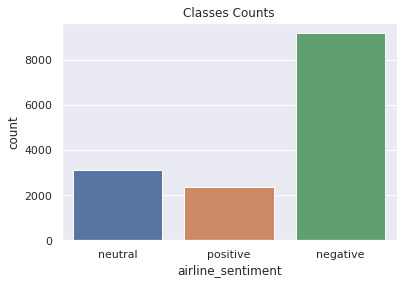

In [ ]:
#Visualizing Y-target in our dataset
sns.set(style="darkgrid")
sns.countplot(x = "airline_sentiment" , data = data).set_title('Classes Counts')
plt.show()

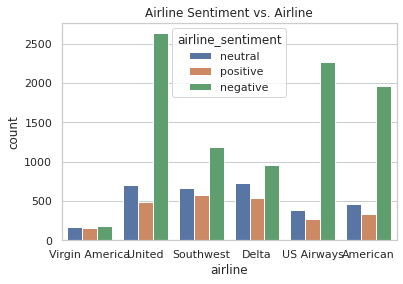

In [ ]:
#Plot Airline Sentiment vs. Airline
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="airline", hue="airline_sentiment", data=data)
plt.title('Airline Sentiment vs. Airline')
plt.show()

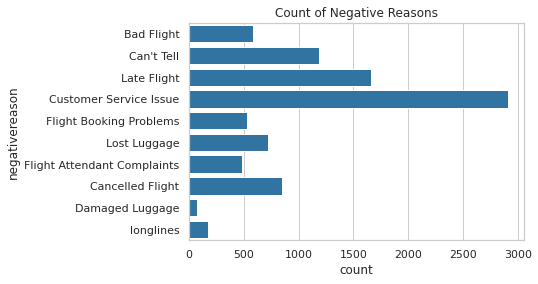

In [ ]:
# Plot Count of Negative Reasons 
ax = sns.countplot(y="negativereason", color='tab:blue', data=data)
plt.title('Count of Negative Reasons')
plt.show()

## Preprocess Data

Before we move forward to word cloud analysis and machine learning models, we would like to spend a few time to further parse the data to make it clean enough for the later tasks. The work flow is briefly summarized as following:\
(1) Remove mentions. \\
(2) Splitting. \\
(3) Convert the words to lower cases. \\
(4) Remove the stopping words in sentences. \\
(5) Remove all punctuation. \\
After such processes, we would be able to move forward to move extensive analysis and implement the machine learning models on the data. 

In [ ]:
#Cleaning the dataset
#Replacing negative with 0, netural with 1, positive with 2 
data.replace({'airline_sentiment' : { 'negative' : 0, 'neutral' : 1, 'positive' : 2 }},inplace=True)

In [ ]:
#removing stopword
stop_words = set(stopwords.words('english'))
def tokenize_content(content):
  #remove_men = re.sub('([^\s\w]|_@?)+', '', content)#remove memtions
  split_word =  [word for word in content.split()]#split
  lower_list = [item.lower() for item in split_word] #convert to lower cases
  remove_stop_list = [ x for x in lower_list if not x in stop_words] #remove stop words
  remove_pun = [ x for x in remove_stop_list if x.isalpha() ] #remove punctuation
  result = []
  for i in remove_pun:
    if 'http' not in i and i != 'RT' and not i.startswith('@'):
      result.append(i)
  return(result)
def join_content(content):
  return(" ".join(content))
data.text = data['text'].apply(lambda item: tokenize_content(item))
data.text = data['text'].apply(lambda item: join_content(item))
#Dataframe for only analyzing text 
text_df = data[['text','airline_sentiment']]
text_df

,text,airline_sentiment
0,,1
1,plus added commercials,2
2,must mean need take another,1
3,really aggressive blast obnoxious faces little...,0
4,really big bad thing,0
...,...,...
14635,thank got different flight,2
14636,leaving minutes late warnings communication mi...,0
14637,please bring american airlines,1
14638,change answer suggestions make,0


## Word Cloud (EDA Part II)

We would like to further take a look at the frequency of the words in thesentiment to see the most representative words that appears in each class.The word cloud that includes the summary of different class is shown in figure  4  from  which  we  could  easily  summarize  some  words  that  seem  to  becritical in expressing the customers’ mood.  For instance: In the word cloud of positive feedback,  we would find words that containspositive information such as:  thank, help, know, etc.In the word cloud of negative feedback, we would find words that contains negative information such as:  delay, cancelled flight, know, late flight, flightcancelled, etc. \

While  from  the  word  cloud  of  neutral  feedback,  we  would  find  more  mildwords such as:  please, change, check, make, see, etc.We can tell that from the word cloud for the negative reviews, the representative words seem to be very similar with what we observed in the negativereasons figure shown in figure 3. We want to further propose the way that we would like to analyze this dataset.  We would like to split the data set into two groups:  (1) negative reviews (2) positive and neutral reviews. \

There are at least three reasons for doing this:  (1) the airline company who is interested in this analysis would put more attention on the negative reviews and would like to treat the others as one group, (2) the word cloudtells  us  the  positive  review  and  neutral  review  do  not  have  significant  difference, (3) merging the positive and neutral together would further help us balance the data to make sure each group has roughly same number of data.

(-0.5, 399.5, 199.5, -0.5)

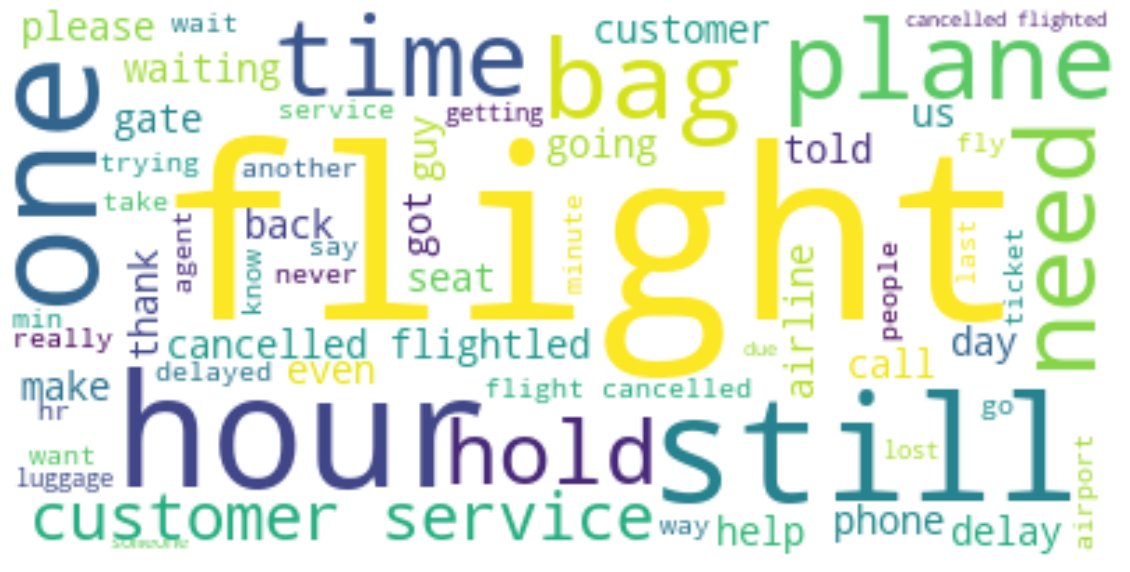

In [ ]:
#Visualizing Word Cloud 
#Negative Word Cloud
plt.figure(figsize = (20,20))
wc = WordCloud(max_words=60,background_color ='white').generate(" ".join(text_df[text_df.airline_sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

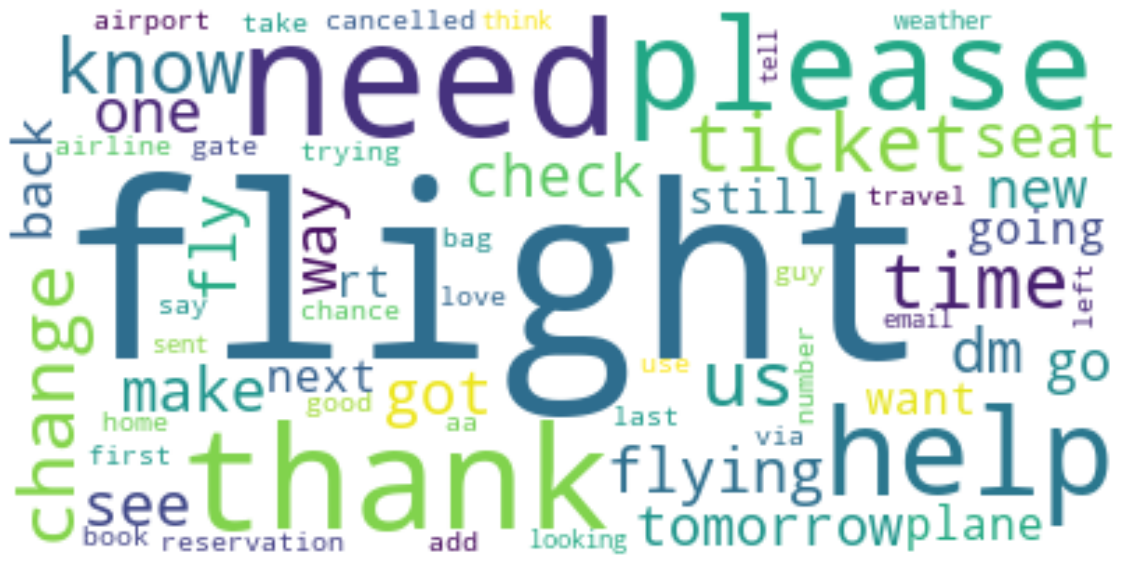

In [ ]:
#Visualizing Word Cloud 
#Netural Word Cloud
plt.figure(figsize = (20,20))
wc = WordCloud(max_words=60,background_color ='white').generate(" ".join(text_df[text_df.airline_sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

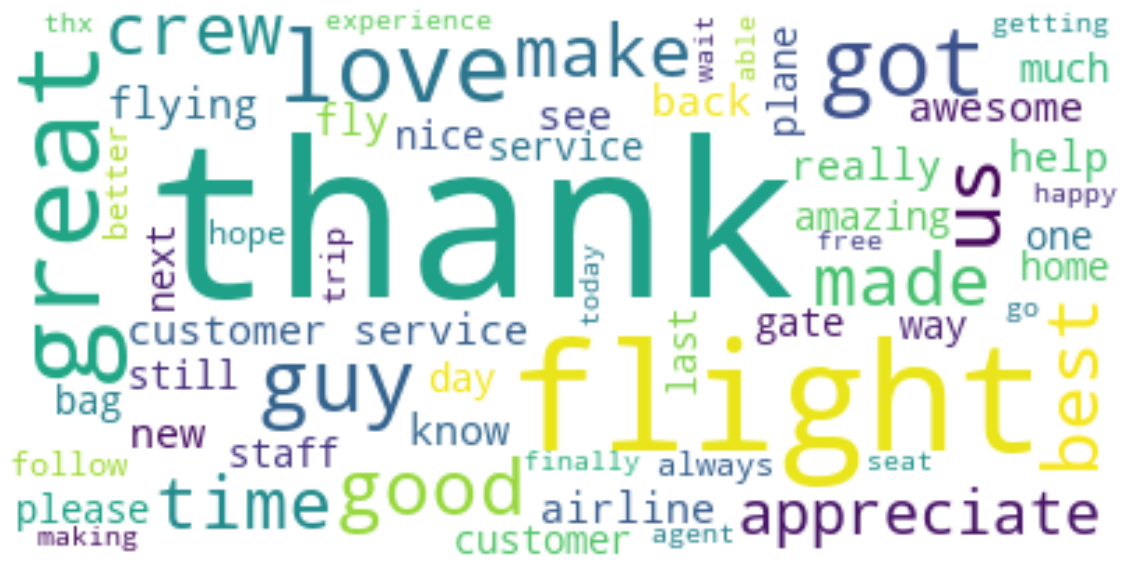

In [ ]:
#Visualizing Word Cloud 
#Positive Word Cloud
plt.figure(figsize = (20,20))
wc = WordCloud(max_words=60,background_color ='white').generate(" ".join(text_df[text_df.airline_sentiment == 2].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

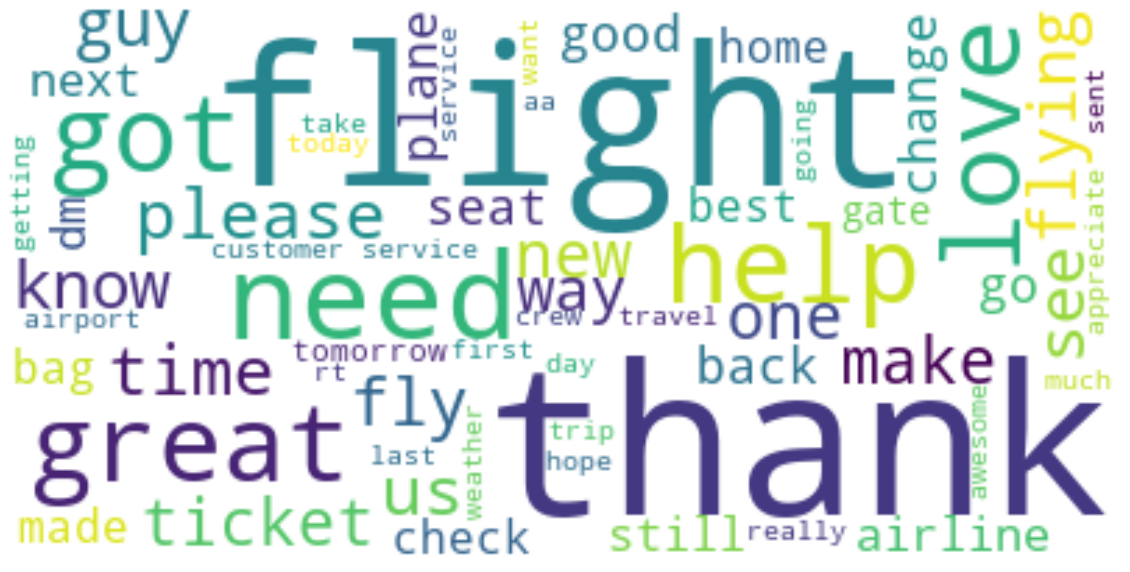

In [ ]:
#Visualizing Word Cloud 
#Positive Word Cloud
plt.figure(figsize = (20,20))
wc = WordCloud(max_words=60,background_color ='white').generate(" ".join(text_df[text_df.airline_sentiment.isin([1, 2])].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")

## Modeling

### Feature Extraction

We consider to embed the data into a long vector so that we can run machine learning methods on that.  Specially, vectorize the sentence accordingto the words frequency (count) is a simple way to do so.  One benefit would be:  all sentences are having the same length and could be a good suit for theinput format of machine learning models we will later use

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

#Combine positive and neutral comments
y = text_df['airline_sentiment'].apply(lambda x: 0 if x==0 else 1)
#Vectorize feature space by counts of each word
v = CountVectorizer(analyzer = "word")
features = v.fit_transform(text_df['text'])
vocab = list(v.vocabulary_.keys())

#Balancing Dataset
#Using Random Oversampling method
from collections import Counter
# print(sorted(Counter(y).items()))
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(features,y)
# print(sorted(Counter(y_resampled).items()))
#print(len(X_resampled))
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=100,stratify=y_resampled)

[(0, 9178), (1, 5462)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Models

In [ ]:
train_acc_list = []
test_acc_list = []
f1_score_list = []

Logistic regression is widely used in binary classification problem.  It isa  special  class  of  generalized  linear  model.   This  method  is  simple  andcould run efficiently on large data set and has the property to prone against overfitting.  We consider use this method as a baseline for this project.

In [ ]:
#Implement Logistic Regression from sklearn library
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(random_state=0, max_iter=200).fit(X_train, y_train)
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
f1 = f1_score(y_test, clf.predict(X_test), average=None)
train_acc_list.append(train_acc)
test_acc_list.append(test_acc)
f1_score_list.append(f1)
print('train_acc', train_acc)
print('test_acc', test_acc)
print('f1_score', f1)

train_acc 0.9023202153570055
test_acc 0.8278867102396514
f1_score [0.82167043 0.83368421]


Decision tree is one of the most popular tools we have learnt in ourclass.  It is well know for the information gain on the training process and provide accurate prediction.  While the depth of the decision tree needs finetuning and there is a high likelihood that such method is tend to overfit and introduce high bias

In [ ]:
#Implement Decision Tree Classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=50).fit(X_train, y_train)
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
f1 = f1_score(y_test, clf.predict(X_test), average=None)
train_acc_list.append(train_acc)
test_acc_list.append(test_acc)
f1_score_list.append(f1)
print('train_acc', train_acc)
print('test_acc', test_acc)
print('f1_score', f1)

train_acc 0.8392513780284578
test_acc 0.7741466957153231
f1_score [0.73843566 0.80127796]


Random forest is a bagging method that combines a set of decisiontree to make a final prediction using vote.  Such method is a more advanceddecision tree model and could help a lot mitigating the bias introduced bya singe decision tree.  We would expect this model to perform better thandecision tree

In [ ]:
#Implement Random Forest Classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=50, random_state=0).fit(X_train, y_train)
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
f1 = f1_score(y_test, clf.predict(X_test), average=None)
train_acc_list.append(train_acc)
test_acc_list.append(test_acc)
f1_score_list.append(f1)
print('train_acc', train_acc)
print('test_acc', test_acc)
print('f1_score', f1)

train_acc 0.8820023073964877
test_acc 0.8246187363834423
f1_score [0.80718563 0.83916084]


More interestingly, random forest enables us to plot the importance of each feature used in the training.  Weare also reporting these features in figure 5 right panel.  By looking at thisfigure,  we can conclude that the marked out features are really expressingthe emotion of the feedback such as ”afraid”, ”embarrassment”, ”occupied”,”preventing”, etc

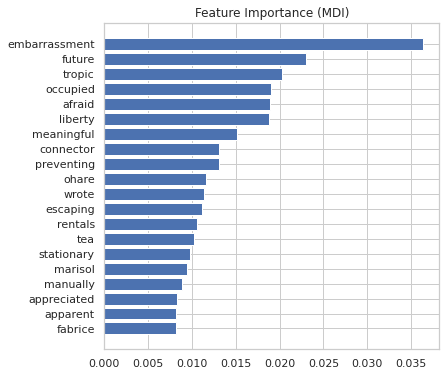

In [ ]:
#Plot Feature Importance for Random Forest Classifier
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx[-20:].shape[0]) + .5
fig = plt.figure(figsize=(6, 6))
plt.barh(pos, feature_importance[sorted_idx][-20:], align='center')
plt.yticks(pos, np.array(vocab)[sorted_idx][-20:])
plt.title('Feature Importance (MDI)')
plt.show()

Support  vector  machine is  a  popular  machine  learning  method  well known for its application if classification problems.  Several variants of sup-port vector machine are proposed to address the non-perfect linear separat-able data, data transformation using kernel methods, etc.

In [ ]:
#Implement Support Vector Machine in sklearn library
from sklearn.svm import SVC

clf = SVC().fit(X_train, y_train)
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
f1 = f1_score(y_test, clf.predict(X_test), average=None)
train_acc_list.append(train_acc)
test_acc_list.append(test_acc)
f1_score_list.append(f1)
print('train_acc', train_acc)
print('test_acc', test_acc)
print('f1_score', f1)

train_acc 0.9528265606973465
test_acc 0.859840232389252
f1_score [0.85703704 0.86253561]


Adaboost is a very popular boosting method that achieves state-of-the-art robustness in the classification problems and is used for facial detection problems,  feature  selections,  etc.   Adaboost  is  sensitive  to  noisy  data  andoutliers,  we  would  expect  it  to  help  with  determing  the  important  words appear in each reviews from our word bag.  Ideally, the accuracy of Adaboost should be higher then the previous mentioned methods

In [ ]:
#Implement AdaBoost Classifier in sklearn library
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
f1 = f1_score(y_test, clf.predict(X_test), average=None)
train_acc_list.append(train_acc)
test_acc_list.append(test_acc)
f1_score_list.append(f1)
print('train_acc', train_acc)
print('test_acc', test_acc)
print('f1_score', f1)

train_acc 0.7682989360338418
test_acc 0.7578068264342774
f1_score [0.73996101 0.77336052]


### Summary

We  summarize  the  performance  of  each method below from  which we can see the logistic regression is performing unexpectedly well.  We think this is because of its property of preventing over-fitting and also the reality that the embedding we are using is not leveraging the global information.  A good observation is random forest model compared with decision tree modelis safe-guard from over-fitting while also provide improvement in terms of the accuracy.  Comparing the logistic regression with SVM, we can see although SVM is giving good testing accuracy, the model is prone to over-fitting byproviding very large training-testing accuracy discrepancy.  This also justifies that logistic regression is a simple but powerful model.  Throughout all the methods we are using, we can see the Adaboost is exhibiting the leasttraining-testing discrepancy and is better than random forest.  One can say, Adaboost is potentially a better tool here as it at least requires less hyperparameter tuning.  

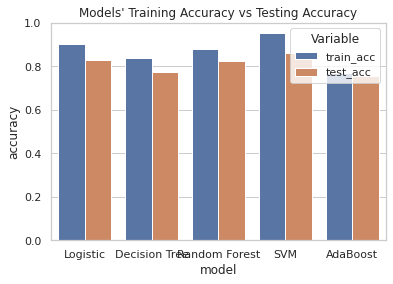

In [ ]:
#Plot Models' Training Accuracy vs Testing Accuracy
models = ['Logistic', 'Decision Tree', 'Random Forest', 'SVM', 'AdaBoost']
acc_df = pd.DataFrame([models, train_acc_list, test_acc_list]).transpose()
acc_df.columns = ['model', 'train_acc', 'test_acc']
tidy = acc_df.melt(id_vars='model').rename(columns=str.title)

sns.barplot(x='Model', y='Value', hue='Variable', data=tidy)
plt.ylabel('accuracy')
plt.xlabel('model')
plt.title("Models' Training Accuracy vs Testing Accuracy")
plt.show()

## Challenges

In this section, we would like to briefly discuss about the potential challenges we will meet during this process

###Dealing with unbalanced data

We can see that the number of data in the summary of figure is not balanced. Specially, the number of negative feedback is more 9,000 while the number of feedback for positive and neutral are only 2,000 and 3,000. As discussed in section , we showed our way of handling the unbalance in the data by merging the neutral class into positive class and do a binary classification on that. However, this still seems not sufficient enough because the total number of data for positive and neutral are less than 6,000. In this case, we need to consider more tricks for balancing the data. There are at least four ways we think could approach this problem: \\

(1) Data augmentation via bootstrap: we can upsample the data in the combination of positive and neutral data using bootstrap  to increase the number of data so that the upsampled data could match the negative reviews.  \\

(2) Down sampling: we can down sample the negative review data into subsets to match the other class. As the combination of positive and neutral are around 5,000 data, we do not loss too much and could still capture the original data distribution information. \\

(3) Use boosting methods. We can split each class into small group of data and use boostingto adaptively tune the weights of each group. Such approach would take advantage all the data information for our inference task. \\

(4) Use weighted loss. We can assign the weights to the loss function of each class according to the number of data contains in each. In this case, the gradient information could be balanced by the number of data to further achieve robust training behavior. 

###Embedding the reviews

As is well known, the embedding of words is playing a critical role in the sentiment analysis. A good embedding would enable the researchers to capture the local and global information of language. There are several ways to tackle this task: \\

(1) If we discard the local information of a sentence, we can use the frequency information of the words that appear in each sentence to embed a whole review. \\

(2) In language modeling, there exists a popular embedding dictionary word2vec that embeds each word into a vector. Such approach would capture more local information between words.  \\

(3) Glove embedding is a new state-of-the-art methods in word embedding that leverage both global and local information of languages for word embedding that achieved the best performance in language modeling.

## Future Directions

We think there are at least two future directions we can consider in addition to what we have done in this report: \\

(1) Besides the proposed methods we will use, we can also try some more advanced methods for the classification such as: 1D convolutional neural network  XGboost, etc. \\

(2) Besides the accuracy of the prediction we have mentioned, we can further do extensive analysis using the full information of the confusion matrix. Information such as F1 score to study the classification performance on the unbalanced data. 